# Tutorial: CLIP Finetuning and Inference

In [1]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import webdataset as wds
import random
import io
import os

from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchmetrics.classification import F1Score

In [2]:
# Here, choose the GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## Load data

I store the data in binary format using `webdataset` and open the batches while training the model to avoid overloading the memory when training with large datasets. However, I will load the data into memory to make it similar to data saved directly as PNGs, arrays, or tensors. Anyway, you can use another way to store and read the data and use a custom `Dataset` and `DataLoader` from PyTorch.

What should matter to you is `train_data` and `val_data`. Once you have the data like the ones in the mentioned variables, you will be able to use the code directly to train the model. The first dimension of the key called pixel_values is the number of objects in the dataset, and the other dimensions correspond to the pixels and channels.

In [3]:
def get_shards_path(base_path, split):
    shards_path = f'{base_path}/{split}/fold_0'
    shard_files = [f for f in os.listdir(shards_path) if f.endswith(".tar.gz")]
    
    if shard_files:
        min_index = min(int(f.split('-')[1].split('.')[0]) for f in shard_files)
        max_index = max(int(f.split('-')[1].split('.')[0]) for f in shard_files)
        dataset_url = f"{shards_path}/imgs_lc-{{{min_index:06d}..{max_index:06d}}}.tar.gz"
        return dataset_url
    else:
        raise FileNotFoundError(f"No shard files found in the directory: {shards_path}")

def fn_decode(sample):
    for key, value in sample.items():
        if key.endswith(".pth"):
            sample[key] = torch.load(io.BytesIO(value), weights_only=True)
        elif key.endswith(".txt"):
            sample[key] = value.decode("utf-8") 
        elif key.endswith(".cls"):
            sample[key] = int(value) 
    return sample

def get_input_model(sample):
    sample = fn_decode(sample)

    sample_mod = sample['pixel_values.pth']
    sample_mod = sample_mod.permute(1, 2, 0, 3)
    sample_mod = sample_mod.reshape(sample_mod.size(0), sample_mod.size(1), -1)
    sample['pixel_values.pth'] = sample_mod

    input_dict = {
        'id': sample['id.txt'],
        'pixel_values': sample['pixel_values.pth'],
        'y_true': sample['label.cls'],
    }
    return input_dict

def load_data_into_memory(base_path, split):
    dataset_url = get_shards_path(base_path, split)
    dataset = wds.WebDataset(dataset_url, shardshuffle=False)
    data_in_memory = []
    for sample in dataset:
        processed_sample = get_input_model(sample)
        data_in_memory.append(processed_sample)

    data_in_memory_dict = {}
    for key in data_in_memory[0].keys():
        data_in_memory_dict[key] = np.stack([d[key] for d in data_in_memory])
    
    return data_in_memory_dict

# Definir la ruta base
base_path = 'data_6bands_noGrid'

# Cargar los datos de train y val
train_data = load_data_into_memory(base_path, 'train')
val_data = load_data_into_memory(base_path, 'val')

In [4]:
train_data.keys()

dict_keys(['id', 'pixel_values', 'y_true'])

In [5]:
train_data['id']

array(['713', '1124', '1227', ..., '130755807', '130762946', '130779836'],
      dtype='<U9')

In [6]:
train_data['id'].shape

(6278,)

In [7]:
train_data['pixel_values'].shape

(6278, 224, 224, 3)

In [8]:
train_data['y_true']

array([ 1,  3,  4, ...,  3,  5, 11])

Show 3 random images from the training set.

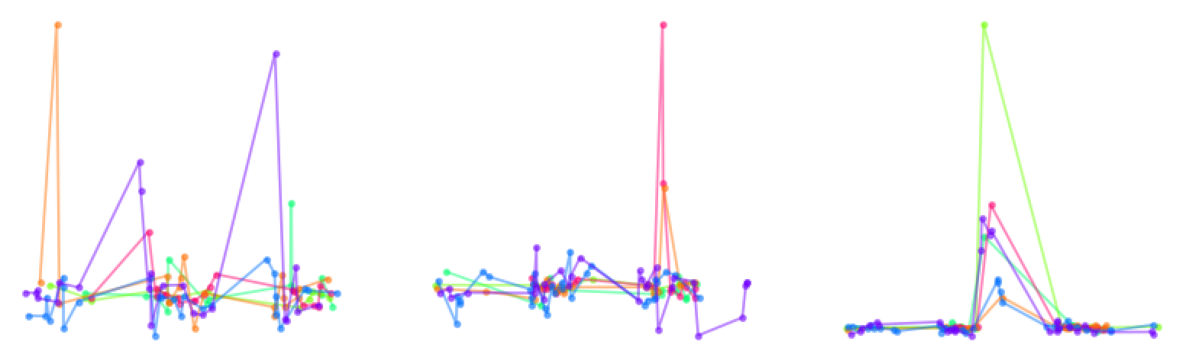

In [9]:
num_images = len(train_data['pixel_values'])
random_indices = random.sample(range(num_images), 3)
images = [train_data['pixel_values'][i] for i in random_indices]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis('off') 

plt.show()

### Dataloader

In [10]:
# I know previously what my class mapping is
dict_mapping_classes = {
  'RR lyrae': 0,
  'AGN': 1,
  'SNII': 2,
  'SNIa': 3,
  'M-dwarf': 4,
  'Eclip. Binary': 5,
  'SNIa-91bg': 6,
  'SLSN-I': 7,
  'SNIbc': 8,
  'TDE': 9,
  'SNIax': 10,
  'Single u-lens': 11,
  'Kilonova': 12,
  'Mira': 13,
  }

inv_dict_mapping_classes = {value: key for key, value in dict_mapping_classes.items()}

Since we don't have captions for each image, we will add a generic prompt here that will be used per class.

In [11]:
prompts = {
    'RR lyrae': 'a photo of a RR lyrae light curve in 6 different bands, a type of variable star',
    'AGN': 'a photo of an AGN light curve in 6 different bands, a type of variable star',
    'SNII': 'a photo of a SNII light curve in 6 different bands, a type of variable star', 
    'SNIa': 'a photo of a SNIa light curve in 6 different bands, a type of variable star', 
    'M-dwarf': 'a photo of a M-dwarf light curve in 6 different bands, a type of variable star', 
    'Eclip. Binary': 'a photo of an Eclipsing Binary light curve in 6 different bands, a type of variable star', 
    'SNIa-91bg': 'a photo of a SNIa-91bg light curve in 6 different bands, a type of variable star', 
    'SLSN-I': 'a photo of a SLSN-I light curve in 6 different bands, a type of variable star', 
    'SNIbc': 'a photo of a SNIbc light curve in 6 different bands, a type of variable star', 
    'TDE': 'a photo of a TDE light curve in 6 different bands, a type of variable star', 
    'SNIax': 'a photo of a SNIax light curve in 6 different bands, a type of variable star',
    'Single u-lens': 'a photo of a Single u-lens light curve in 6 different bands, a type of variable star', 
    'Kilonova': 'a photo of a Kilonova light curve in 6 different bands, a type of variable star', 
    'Mira': 'a photo of a Mira light curve in 6 different bands, a type of variable star', 
}

In [12]:
num_classes = len(np.unique(train_data['y_true']))
num_classes

14

In [13]:
batch_size = 64

class CustomDataset(Dataset):
    def __init__(self, data, prompts):
        self.ids = data['id']
        self.pixel_values = torch.from_numpy(data['pixel_values']).float()
        self.y_true = torch.from_numpy(data['y_true']).long()

        self.prompts = prompts

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return {
            'id': self.ids[idx],
            'pixel_values': self.pixel_values[idx],
            'texts': self.prompts[inv_dict_mapping_classes[self.y_true[idx].item()]],
            'y_true': self.y_true[idx]
        }

train_dataset = CustomDataset(train_data, prompts)
val_dataset = CustomDataset(val_data, prompts)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Finetuning

### Model

You can use a classifier if you want, but I am going to show the implementation without a classifier.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pt_model_name = 'openai/clip-vit-base-patch32'
processor = CLIPProcessor.from_pretrained(pt_model_name)
model = CLIPModel.from_pretrained(pt_model_name).to(device)

/home/users/dmoreno2016/.virtualenvs/VLT_tutorial/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Training

In [18]:
def compute_img_to_text_similarity(batch_data, model, processor):
    inputs = processor(text=list(prompts.values()), 
                            images=batch_data['pixel_values'], 
                            return_tensors="pt", 
                            padding=True, 
                            truncation=True).to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image 
    y_pred_prob = logits_per_image.softmax(dim=1)
    return y_pred_prob 
    

def train_step(batch_data, model, processor, optimizer, device):
    model.train()
    y_true = batch_data['y_true'].to(device)

    inputs = processor(text=batch_data['texts'], 
                       images=batch_data['pixel_values'], 
                       return_tensors="pt", 
                       padding=True, 
                       truncation=True).to(device)
    outputs = model(**inputs, return_loss=True)
    loss = outputs.loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_prob = compute_img_to_text_similarity(batch_data, model, processor)
    y_pred = torch.argmax(y_pred_prob, dim=-1)
    return loss.item(), y_pred, y_true
    

def validate_step(batch_data, model, processor, device):
    model.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)

        inputs = processor(text=batch_data['texts'], 
                        images=batch_data['pixel_values'], 
                        return_tensors="pt", 
                        padding=True, 
                        truncation=True).to(device)
        outputs = model(**inputs, return_loss=True)
        loss = outputs.loss

        y_pred_prob = compute_img_to_text_similarity(batch_data, model, processor)
        y_pred = torch.argmax(y_pred_prob, dim=-1)
        return loss.item(), y_pred, y_true


def predict_step(batch_data, model, processor, device):
    model.eval()
    with torch.no_grad():
        y_true = batch_data['y_true'].to(device)
        
        inputs = processor(text=batch_data['texts'], 
                        images=batch_data['pixel_values'], 
                        return_tensors="pt", 
                        padding=True, 
                        truncation=True).to(device)
        outputs = model(**inputs, return_loss=True)
        loss = outputs.loss

        y_pred_prob = compute_img_to_text_similarity(batch_data, model, processor)
        y_pred = torch.argmax(y_pred_prob, dim=-1)

        return {
            'id': batch_data['id'],
            'y_pred': y_pred.cpu().numpy(),
            'y_pred_prob': y_pred_prob.cpu().numpy(),
            'y_true': y_true.cpu().numpy()
        }

In [16]:
lr = 2e-5 # 5.0e-6
num_epochs = 1000
patience = 7 
best_val_f1 = 0.0
patience_counter = 0
best_model_path = 'best_model_clip.pth'  # Ruta donde se guardará el mejor modelo

params = list(model.parameters())
optimizer = optim.Adam(params, lr=lr)

# Inicializar métricas F1
f1_train = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)
f1_val = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)

# Bucle de entrenamiento y validación
for epoch in range(num_epochs):
    # Resetear métricas para cada epoch
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    f1_train.reset()

    model.train()
    for batch_idx, batch_data in enumerate(train_dataloader):
        loss, y_pred, y_true = train_step(batch_data, model, processor, optimizer, device)
        
        train_loss += loss
        train_correct += (y_pred == y_true).sum()
        train_total += y_true.size(0)

        # Actualizar F1 Score para el conjunto de entrenamiento
        f1_train.update(y_pred, y_true)

    train_loss /= len(train_dataloader)
    train_accuracy = 100. * train_correct / train_total
    train_f1_score = f1_train.compute()

    # Validación
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    f1_val.reset()

    model.eval()
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(val_dataloader):
            loss, y_pred, y_true = validate_step(batch_data, model, processor, device)
            
            val_loss += loss
            val_correct += (y_pred == y_true).sum()
            val_total += y_true.size(0)

            # Actualizar F1 Score para el conjunto de validación
            f1_val.update(y_pred, y_true)

    val_loss /= len(val_dataloader)
    val_accuracy = 100. * val_correct / val_total
    val_f1_score = f1_val.compute()

    # Imprimir resultados de la época
    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Train F1: {train_f1_score:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | Val F1: {val_f1_score:.4f}')

    # Early stopping basado en el F1 Score de validación y guardado del mejor modelo
    if val_f1_score > best_val_f1:
        best_val_f1 = val_f1_score
        patience_counter = 0  # Restablecer el contador de paciencia
        torch.save(model.state_dict(), best_model_path)  # Guardar el mejor modelo
        print(f"New best model saved at epoch {epoch+1}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

print(f"Training complete. Best model saved with F1 Score: {best_val_f1:.4f}")

Epoch 1/1000 | Train Loss: 4.1721 | Train Acc: 9.17% | Train F1: 0.0619 | Val Loss: 4.1222 | Val Acc: 11.15% | Val F1: 0.0484
New best model saved at epoch 1
Epoch 2/1000 | Train Loss: 4.1259 | Train Acc: 6.91% | Train F1: 0.0481 | Val Loss: 4.1334 | Val Acc: 3.06% | Val F1: 0.0042
Epoch 3/1000 | Train Loss: 4.1325 | Train Acc: 4.43% | Train F1: 0.0174 | Val Loss: 4.1266 | Val Acc: 7.20% | Val F1: 0.0422
Epoch 4/1000 | Train Loss: 4.1372 | Train Acc: 3.90% | Train F1: 0.0366 | Val Loss: 4.1319 | Val Acc: 0.64% | Val F1: 0.0034
Epoch 5/1000 | Train Loss: 4.1321 | Train Acc: 4.05% | Train F1: 0.0266 | Val Loss: 4.1379 | Val Acc: 1.91% | Val F1: 0.0028
Epoch 6/1000 | Train Loss: 4.1013 | Train Acc: 6.44% | Train F1: 0.0530 | Val Loss: 4.0468 | Val Acc: 8.34% | Val F1: 0.0827
New best model saved at epoch 6
Epoch 7/1000 | Train Loss: 3.9393 | Train Acc: 14.13% | Train F1: 0.1125 | Val Loss: 3.8989 | Val Acc: 18.03% | Val F1: 0.1219
New best model saved at epoch 7
Epoch 8/1000 | Train Loss:

## Inference

Here, you should use the test data; however, I will use the validation data.

In [19]:
# Cargar el mejor modelo guardado
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()

outputs = []
with torch.no_grad():
    for batch_data in val_dataloader: 
        outputs.append(predict_step(batch_data, model, processor, device))

In [21]:
outputs[0].keys()

dict_keys(['id', 'y_pred', 'y_pred_prob', 'y_true'])

In [22]:
keys = outputs[0].keys()
outputs_dict = {key: [] for key in keys}

for i in range(len(outputs)):
    for key in keys:
        outputs_dict[key].append(outputs[i][key])

outputs_dict = {key: np.concatenate(values) for key, values in outputs_dict.items()}
outputs_dict

{'id': array(['615', '730', '745', ..., '130659834', '130727624', '130772921'],
       dtype='<U9'),
 'y_pred': array([ 0,  6,  3, ...,  3,  4, 12]),
 'y_pred_prob': array([[9.9615818e-01, 2.1814056e-05, 7.8134735e-06, ..., 1.4156661e-05,
         9.3852437e-09, 2.7111471e-03],
        [6.1704723e-06, 2.7338253e-06, 4.1604540e-05, ..., 9.5934492e-06,
         4.8271781e-05, 7.8224737e-08],
        [1.9656929e-05, 6.7852304e-04, 2.2825738e-03, ..., 6.1476603e-06,
         2.5937152e-05, 1.6425199e-07],
        ...,
        [1.3019373e-04, 5.9211855e-03, 2.7964968e-02, ..., 9.6032218e-06,
         2.0181808e-04, 4.9205642e-06],
        [5.8783815e-05, 2.3979404e-05, 2.1530039e-05, ..., 3.6201156e-05,
         3.1983657e-03, 2.1061905e-07],
        [1.6548447e-04, 2.0804680e-04, 2.5165623e-02, ..., 7.1356300e-04,
         4.4127825e-01, 1.3464156e-05]], dtype=float32),
 'y_true': array([0, 2, 3, ..., 2, 4, 4])}

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(outputs_dict['y_true'], outputs_dict['y_pred'], digits=4))

              precision    recall  f1-score   support

           0     0.8958    0.8958    0.8958        48
           1     0.7778    0.8514    0.8129        74
           2     0.4145    0.5983    0.4897       239
           3     0.6452    0.6926    0.6681       462
           4     0.7786    0.5178    0.6220       197
           5     0.9061    0.8913    0.8986       184
           6     0.3043    0.1667    0.2154        42
           7     0.4286    0.1714    0.2449        35
           8     0.7143    0.1546    0.2542        97
           9     0.4895    0.7071    0.5785        99
          10     0.0526    0.0278    0.0364        36
          11     0.8182    0.2903    0.4286        31
          12     0.0943    0.2500    0.1370        20
          13     1.0000    0.6667    0.8000         6

    accuracy                         0.6064      1570
   macro avg     0.5943    0.4916    0.5059      1570
weighted avg     0.6360    0.6064    0.5977      1570



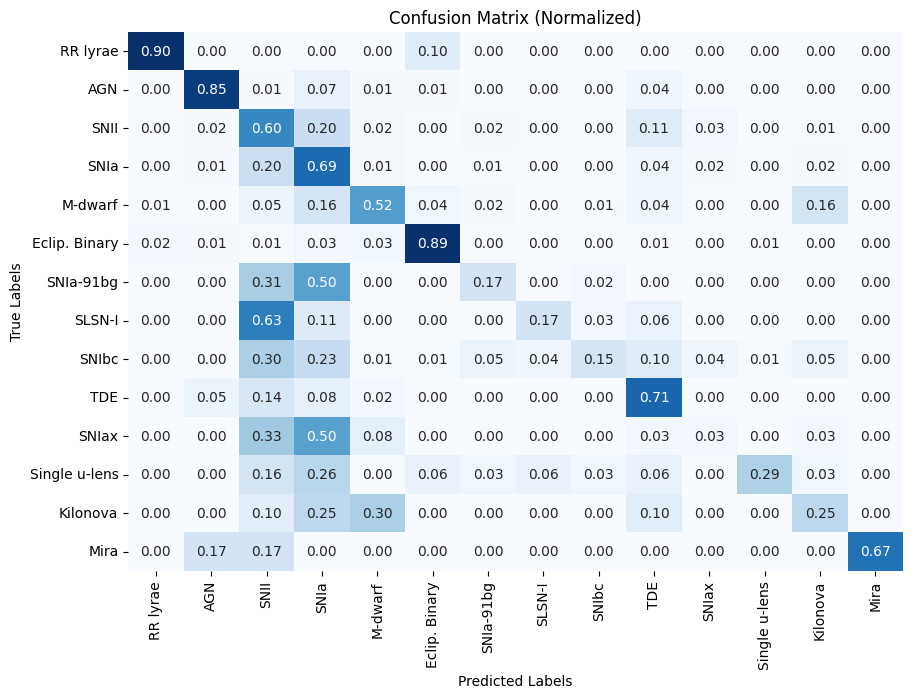

In [24]:
# Crear la matriz de confusión
cm = confusion_matrix(outputs_dict['y_true'], outputs_dict['y_pred'])

# Normalizar la matriz de confusión por filas (verdaderos)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Obtener los nombres de las clases desde el diccionario
class_names = inv_dict_mapping_classes.values()

# Dibujar el heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()